# Introduction

In this project, my goal is to select the model with the best **recall, f1, ROC** metrics because the **accuracy** metric is not the best for our data, where 85% of the data belongs to class 0 and only 15% belongs to class 1.

# Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, roc_curve
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import auc, RocCurveDisplay

import optuna
from optuna.trial import Trial
from imblearn.combine import SMOTEENN

# Load data / EDM

In [2]:
sns.set_theme()

numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

categorical_columns = ['education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'TenYearCHD', 'diabetes', 'sex']

## Load data

In [3]:
data = pd.read_csv("data_cardiovascular_risk.csv")
data.head(10)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
5,5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1
6,6,61,1.0,M,NO,0.0,0.0,0,1,0,238.0,232.0,136.0,24.83,75.0,79.0,0
7,7,36,4.0,M,YES,35.0,0.0,0,0,0,295.0,102.0,68.0,28.15,60.0,63.0,0
8,8,41,2.0,F,YES,20.0,NaN,0,0,0,220.0,126.0,78.0,20.70,86.0,79.0,0
9,9,55,2.0,F,NO,0.0,0.0,0,1,0,326.0,144.0,81.0,25.71,85.0,NaN,0


## Unique values

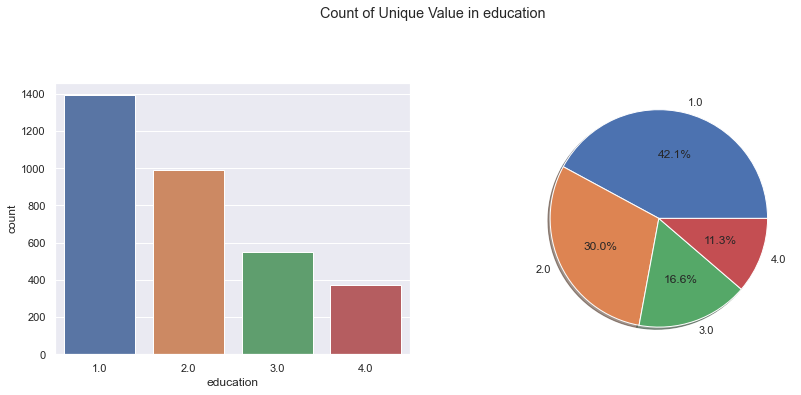

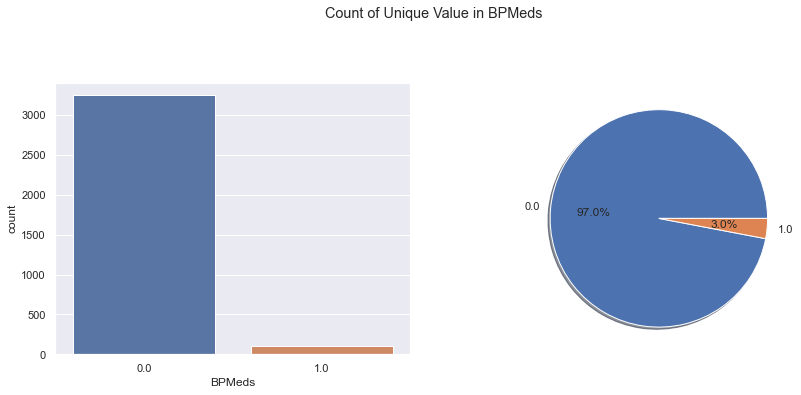

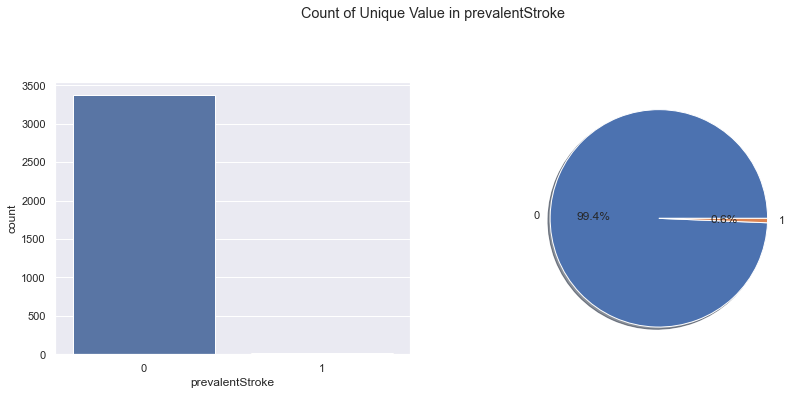

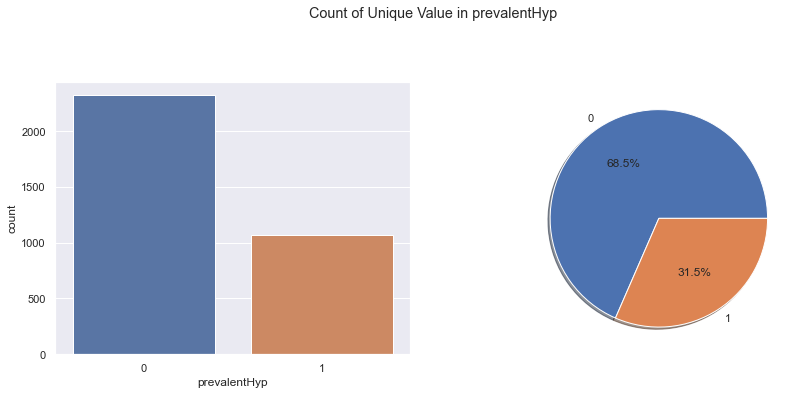

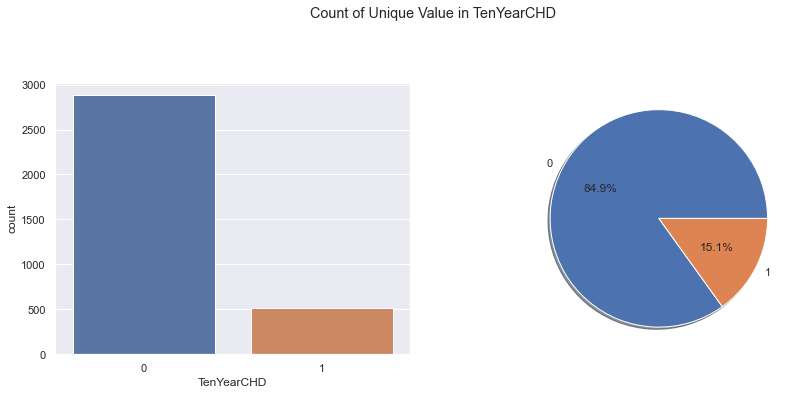

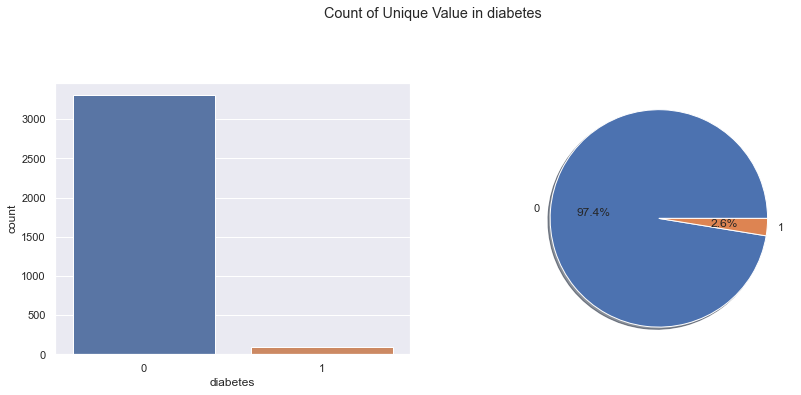

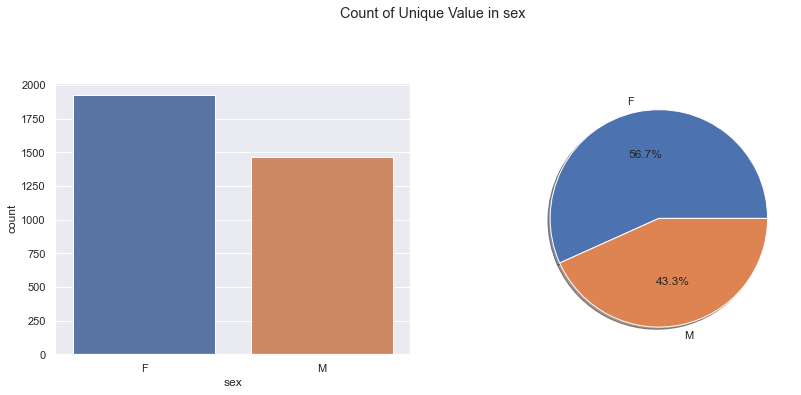

In [4]:
for i, col in enumerate(categorical_columns):

    fig, axes = plt.subplots(1,2,figsize=(14,5))

    # count of col (countplot)
    sns.countplot(data=data, x=col, ax=axes[0])
    # count of col (pie chart)
    slices = data[col].value_counts().sort_index().values
    activities = [var for var in data[col].value_counts().sort_index().index]
    axes[1].pie(slices, labels=activities, shadow=True, autopct='%1.1f%%')

    plt.suptitle(f'Count of Unique Value in {col}', y=1.09)
    plt.show()

## Distribution

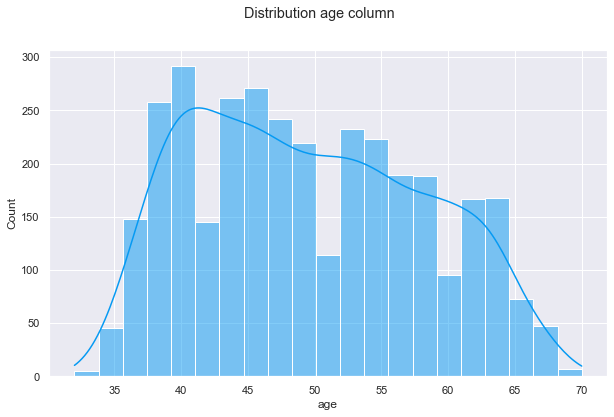

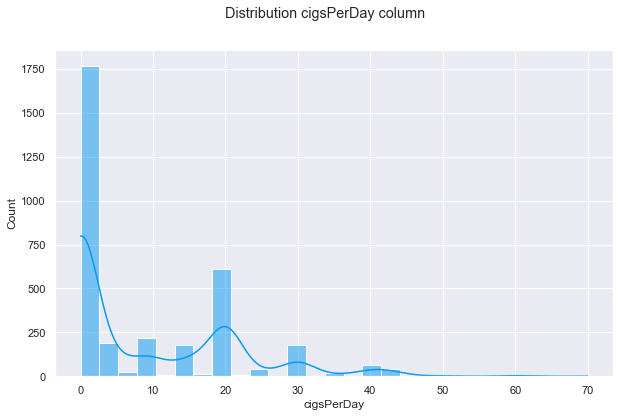

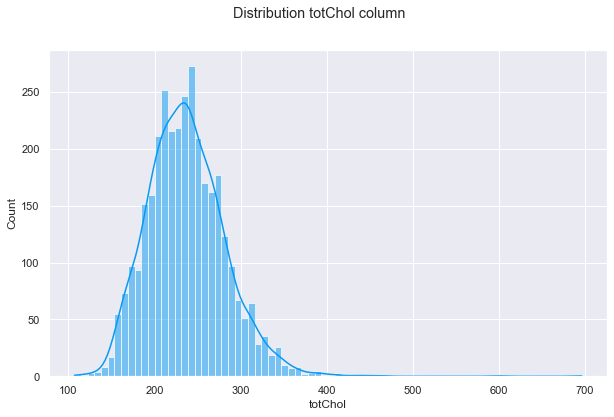

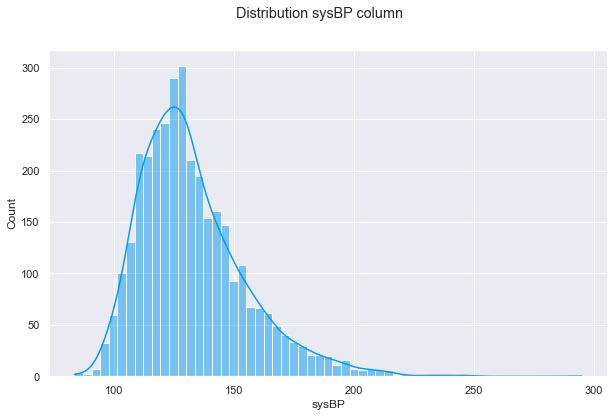

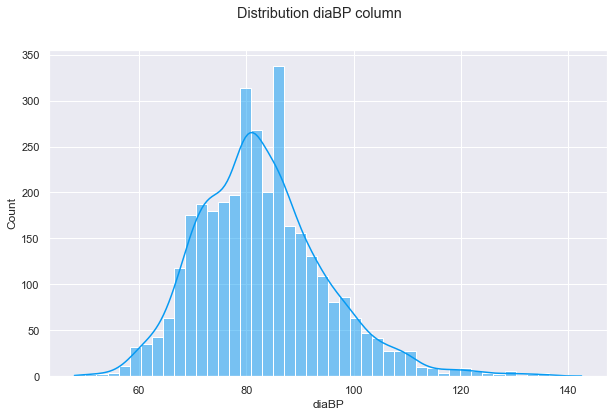

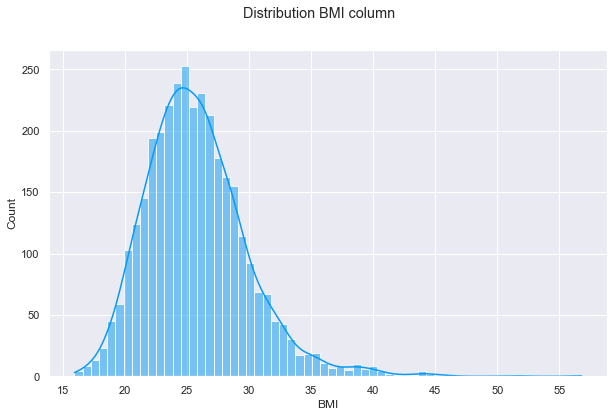

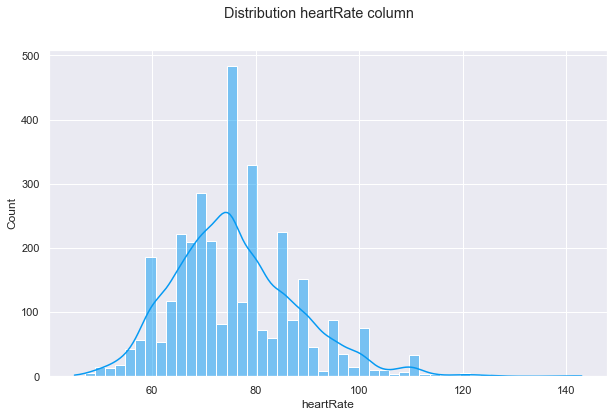

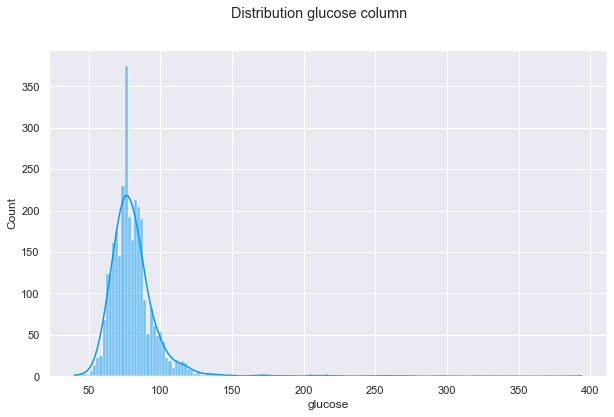

In [5]:
for i, col in enumerate(numerical_columns):
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    
    sns.histplot(data=data, x=col, color='#069AF3', kde=True)
    plt.suptitle(f'Distribution {col} column')

## Correlation matrix

<AxesSubplot:>

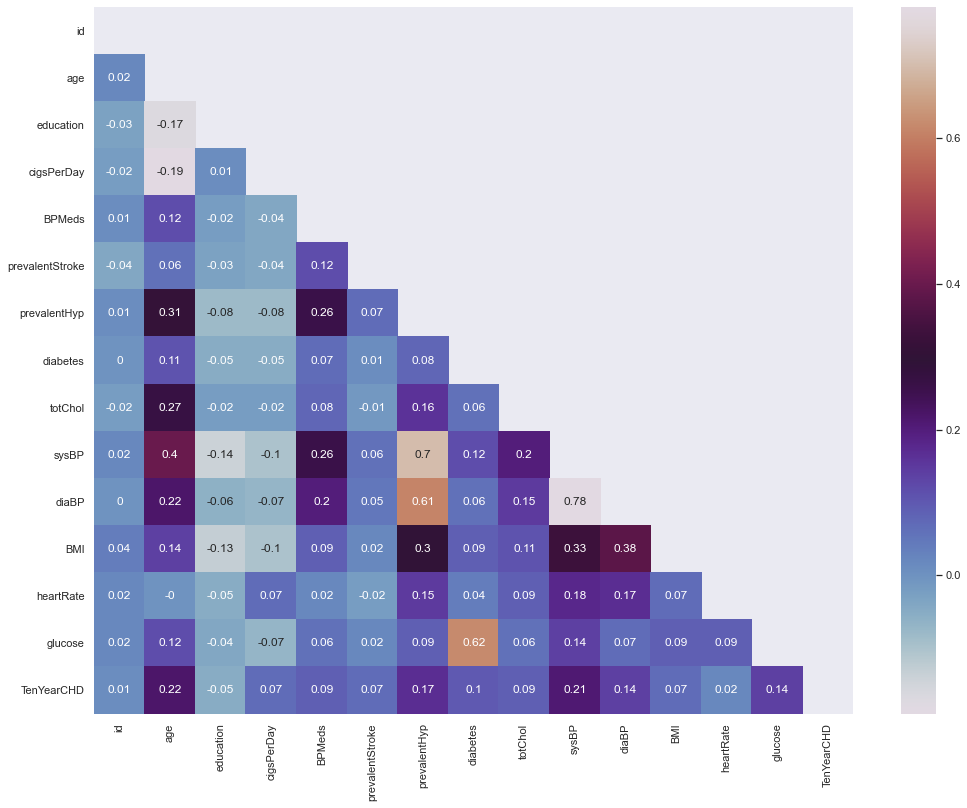

In [6]:
plt.figure(figsize=(17, 13))
mask = np.triu(data.corr())
corr = data.corr().round(2)
sns.heatmap(corr, annot=True, cmap='twilight', mask=mask)

## Chek outliers

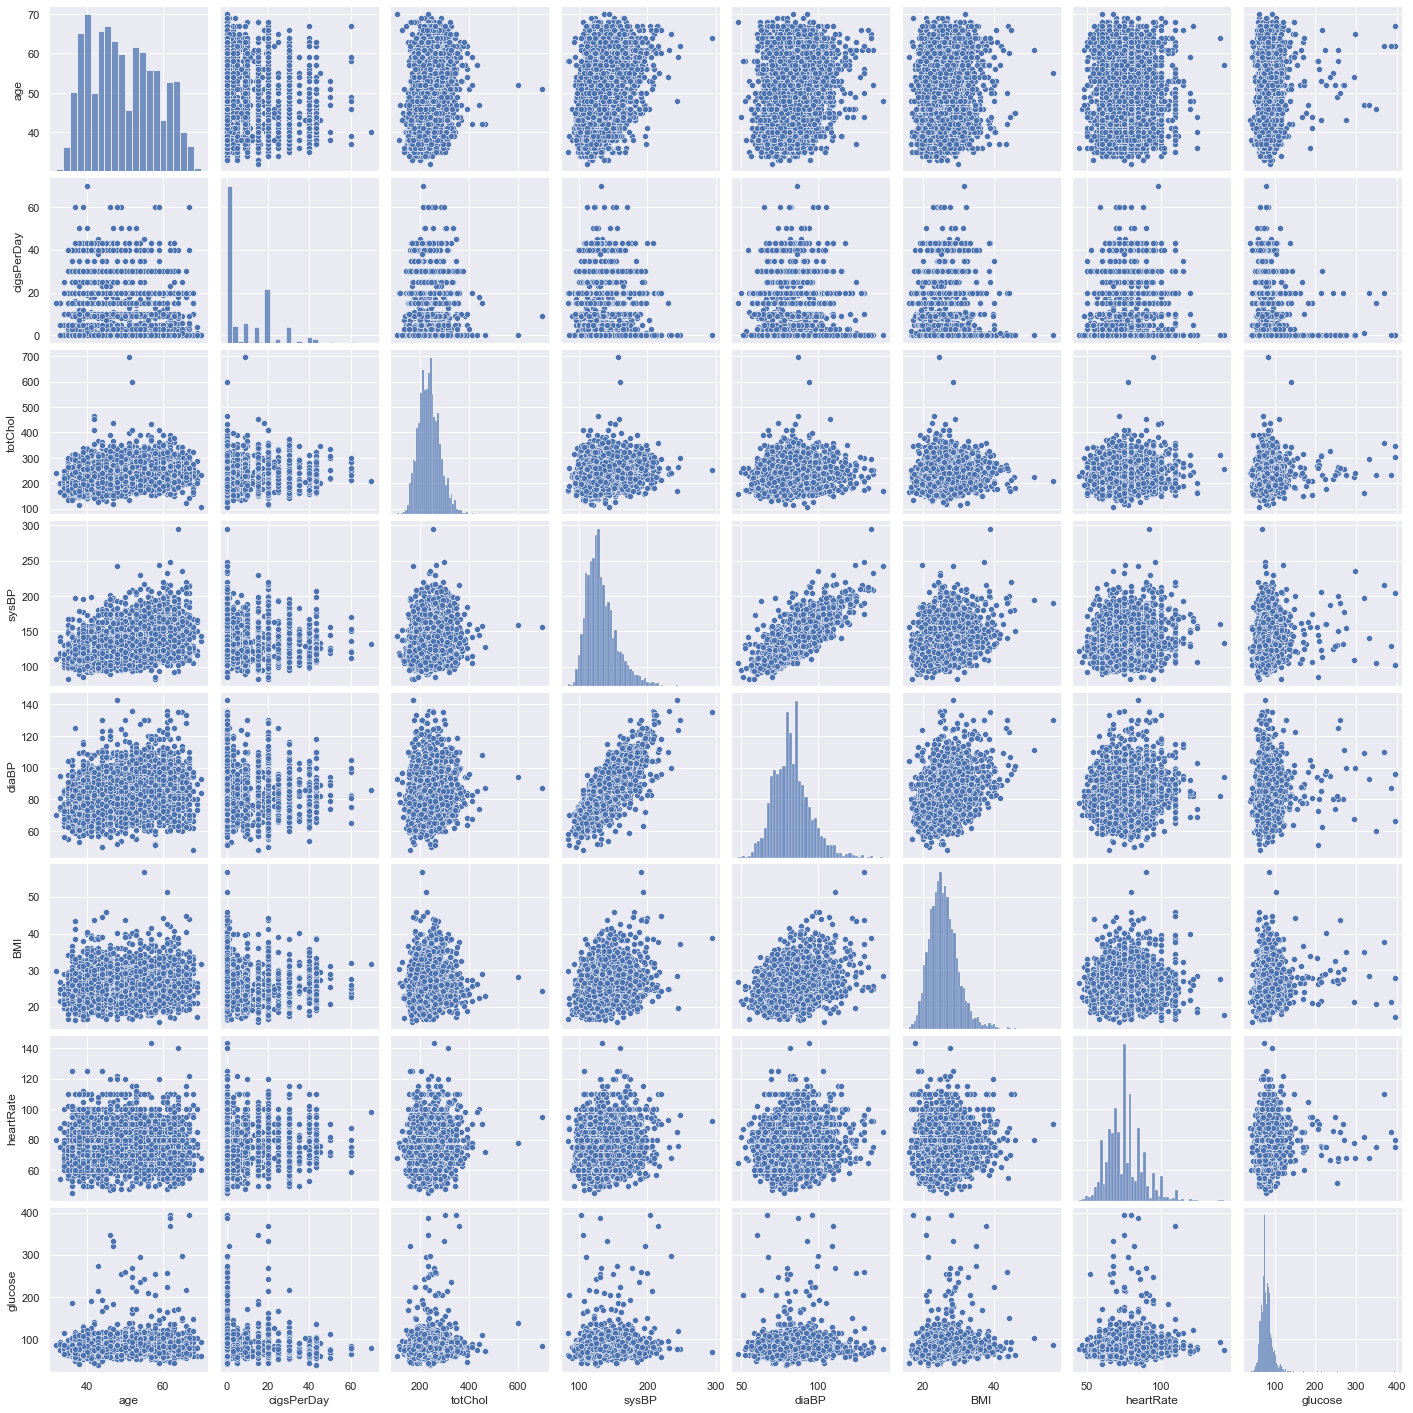

In [7]:
sns.pairplot(data[numerical_columns])

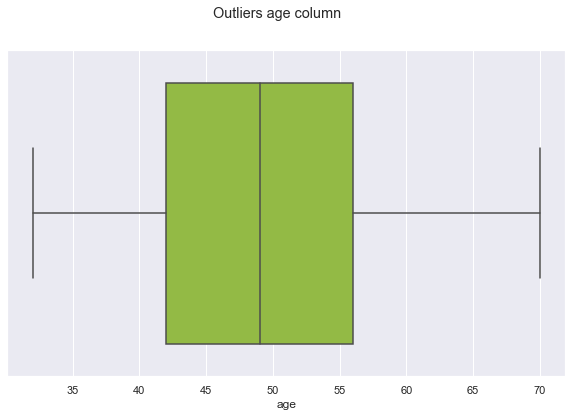

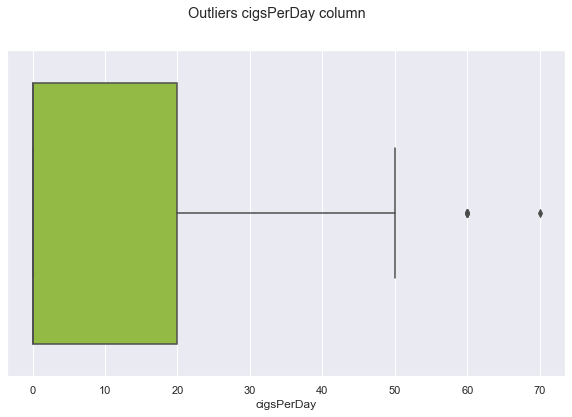

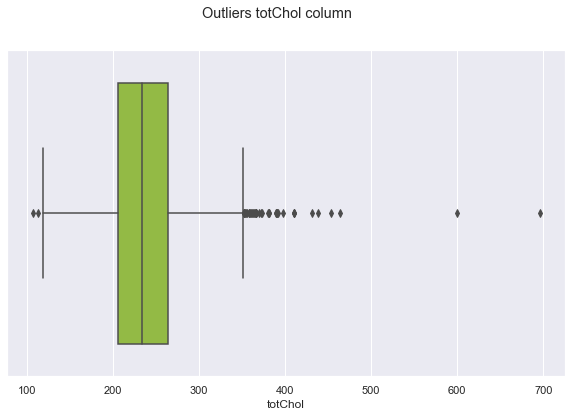

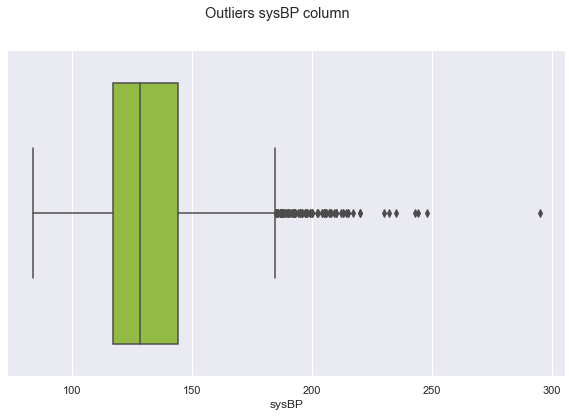

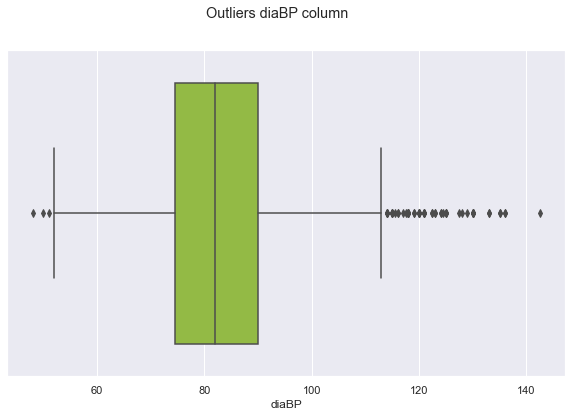

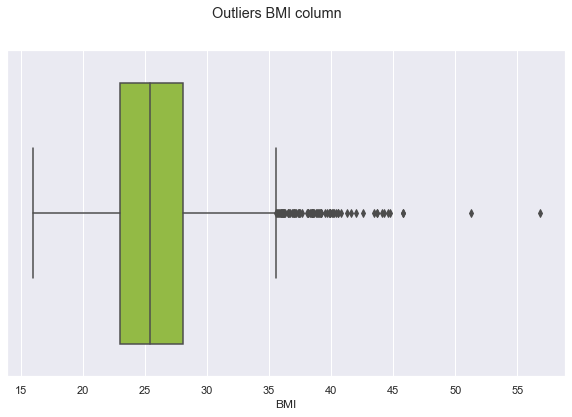

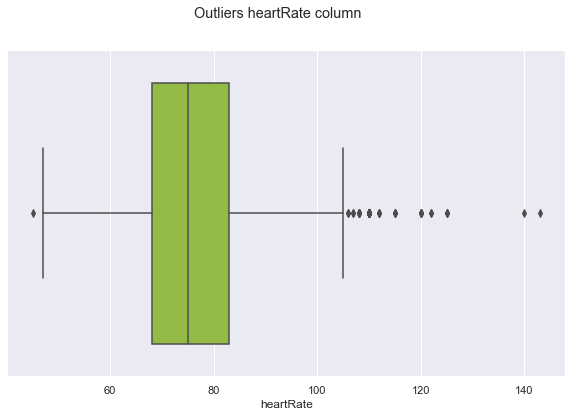

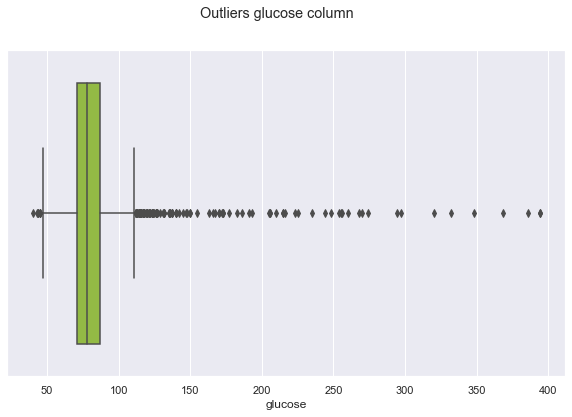

In [8]:
for i, col in enumerate(numerical_columns):
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    
    sns.boxplot(data=data, x=col, color='yellowgreen')
    plt.suptitle(f'Outliers {col} column')

## Describe data

In [9]:
data.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


# Processing data

## Сreate a copy / Fill in missing values

In [10]:
new_data = data.copy()
new_data.isnull().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [11]:
# Impute the 'BPMeds' column
imp_moda = SimpleImputer(strategy='most_frequent')
bpm_transf = imp_moda.fit_transform(new_data[['BPMeds']])
#Education
imp_median = SimpleImputer(strategy='median')
edu_transf = imp_median.fit_transform(new_data[['education']])
#heartRate
new_data['heartRate'] = new_data['heartRate'].fillna(round(new_data['heartRate'].median()))
# totChol
new_data['totChol'].fillna(new_data['totChol'].median(), axis=0, inplace=True)
# BMI
new_data['BMI'].fillna(new_data['BMI'].median(), axis=0, inplace=True)

new_data['education'] = edu_transf
new_data['BPMeds'] = bpm_transf

In [12]:
#Imputation using KNN
KNN_imputer = KNNImputer(n_neighbors=3)
new_data['glucose'] = KNN_imputer.fit_transform(new_data[['glucose']])

KNN_imputer1 = KNNImputer(n_neighbors=3)
new_data['cigsPerDay'] = KNN_imputer1.fit_transform(new_data[['cigsPerDay']])
new_data['cigsPerDay'] = new_data['cigsPerDay'].apply(lambda x: round(x))

## Encoding

In [13]:
enc = OneHotEncoder()
one_hot_encoder = enc.fit_transform(new_data[['sex']])
one_hot_encoder_array = one_hot_encoder.toarray()
enc_column = pd.DataFrame(one_hot_encoder_array, columns=['gender_F', 'gender_M'])
new_data = pd.concat([new_data, enc_column], axis=1)
new_data.head(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,gender_F,gender_M
0,0,64,2.0,F,YES,3,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1,1.0,0.0
1,1,36,4.0,M,NO,0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,0.0,1.0
2,2,46,1.0,F,YES,10,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,1.0,0.0
3,3,50,1.0,M,YES,20,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,0.0,1.0
4,4,64,1.0,F,YES,30,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,1.0,0.0


## Removing columns

The **is_smoking** column can be removed because we can understand whether a person smokes or not from the **cigsPerDay** column. 
Example: if a person does not smoke (**is_smoking** -> **NO**), then the number of cigarettes per day will be 0, and if he smokes, then the number of cigarettes will be greater than or equal to 1.

In [14]:
new_data.drop(columns=['id', 'sex', 'is_smoking'], axis=1, inplace=True)
new_data.head(5)

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,gender_F,gender_M
0,64,2.0,3,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1,1.0,0.0
1,36,4.0,0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,0.0,1.0
2,46,1.0,10,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,1.0,0.0
3,50,1.0,20,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,0.0,1.0
4,64,1.0,30,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,1.0,0.0


## Outliers processing

In [15]:
for el in numerical_columns:
    q1 = new_data[el].quantile(0.25)
    q3 = new_data[el].quantile(0.75)
    IQR = q3 - q1
    low_bound = q1 - 1.5 * IQR
    up_bound = q3 + 1.5 * IQR
    new_data[el] = np.where(new_data[el] < low_bound, np.nan, new_data[el])
    new_data[el] = np.where(new_data[el] > up_bound, np.nan, new_data[el])

new_data.dropna(axis=0, inplace=True)

## Sampling

In [16]:
y = new_data['TenYearCHD']
X = new_data.drop(labels='TenYearCHD', axis=1)

In [17]:
enn = SMOTEENN(random_state=42)
X_resample, y_resample = enn.fit_resample(X, y)

## Train test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=0)

In [19]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Standardization

In [20]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_std = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [21]:
X_train_ns_std = pd.DataFrame(data=scaler.fit_transform(X_train_ns), columns=X_train_ns.columns, index=X_train_ns.index)
X_test_ns_std = pd.DataFrame(data=scaler.transform(X_test_ns), columns=X_test_ns.columns, index=X_test_ns.index)

In [33]:
print(f'X_train with sampling {X_train_std.shape}\ny_train with sampling {y_train.shape}\nX_train with no sampling {X_train_ns_std.shape}\ny_train with no sampling {y_train_ns.shape}')

X_train with sampling (3038, 15)
y_train with sampling (3038,)
X_train with no sampling (2337, 15)
y_train with no sampling (2337,)


# Classification Models

In [34]:
def show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, model=None):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    precision_ns = precision_score(y_test_ns, y_pred_ns)
    recall_ns = recall_score(y_test_ns, y_pred_ns)
    accuracy_ns = accuracy_score(y_test_ns, y_pred_ns)
    f1_ns = f1_score(y_test_ns, y_pred_ns)
    
    metrics_data = pd.DataFrame(
    {'Accuracy': [accuracy, accuracy_ns],
    'Precision': [precision, precision_ns],
    'Recall': [recall, recall_ns],
    'F1': [f1, f1_ns]}, index=[model, f'{model} (not sampled)'])
    
    return metrics_data

In [35]:
def show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns):
    cm = confusion_matrix(y_test, y_pred)
    cm_ns = confusion_matrix(y_test_ns, y_pred_ns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.set_title('With sampling')
    ax2.set_title('Without sampling')

    axes = (ax1, ax2)
    
    for i, el in enumerate([cm, cm_ns]):
        sns.heatmap(el, annot=True, fmt='.2f', ax=axes[i])
        axes[i].set_xlabel('prediction')
        axes[i].set_ylabel('true_labels')

## Logistic Regression

In [36]:
lr_model = LogisticRegression(penalty='l2', C=0.2, solver='liblinear')
lr_model.fit(X_train_std, y_train)
y_pred = lr_model.predict(X_test_std)

lr_model_ns = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced')
lr_model_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = lr_model_ns.predict(X_test_ns_std)

In [37]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'Logistic Regression')

,Accuracy,Precision,Recall,F1
Logistic Regression,0.753947,0.763107,0.858079,0.807811
Logistic Regression (not sampled),0.629060,0.204255,0.615385,0.306709


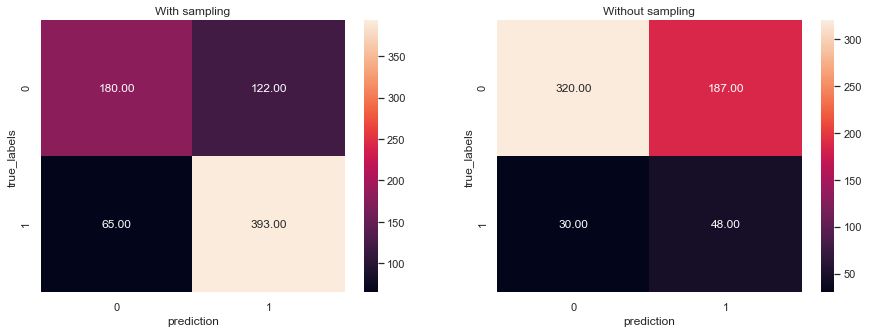

In [38]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

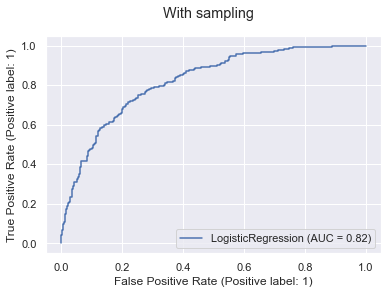

In [48]:
lr_disp = RocCurveDisplay.from_estimator(lr_model, X_test_std, y_test, )
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

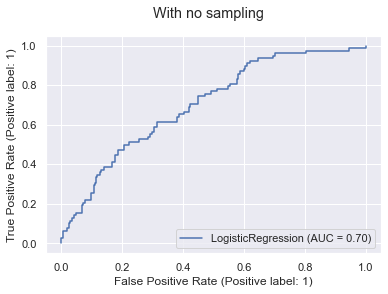

In [49]:
lr_disp = RocCurveDisplay.from_estimator(lr_model_ns, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

## SVC

In [44]:
svc_model = SVC(C=1, random_state=42, probability=True)
svc_model.fit(X_train_std, y_train)
y_pred = svc_model.predict(X_test_std)

svc_model_ns = SVC(random_state=42, probability=True, class_weight='balanced')
svc_model_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = lr_model_ns.predict(X_test_ns_std)

In [45]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'SVC')

,Accuracy,Precision,Recall,F1
SVC,0.830263,0.827038,0.908297,0.865765
SVC (not sampled),0.629060,0.204255,0.615385,0.306709


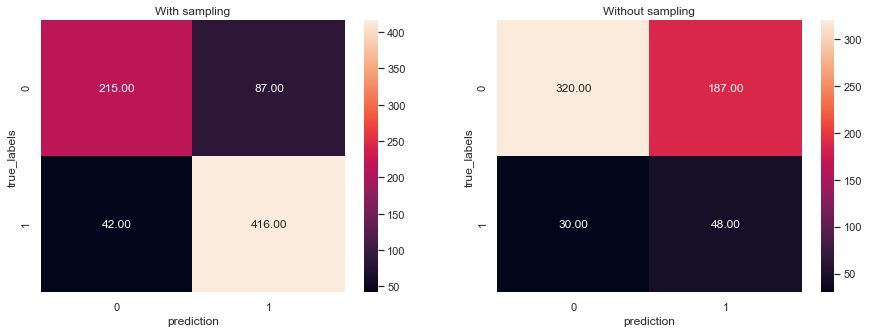

In [46]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

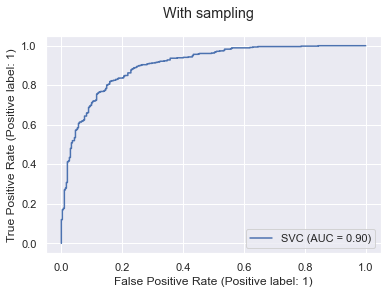

In [50]:
svc_disp = RocCurveDisplay.from_estimator(svc_model, X_test_std, y_test)
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

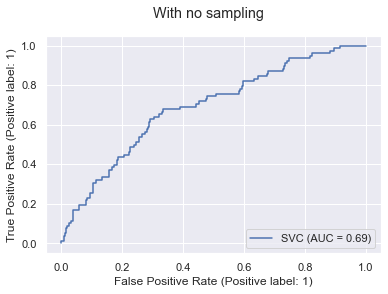

In [51]:
svc_disp = RocCurveDisplay.from_estimator(svc_model_ns, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

## Random Forest

In [52]:
rf_model = RandomForestClassifier(n_estimators=1000, criterion='log_loss',
                        max_depth=6, min_samples_split=4, n_jobs=2, random_state=42)
rf_model.fit(X_train_std, y_train)
y_pred = rf_model.predict(X_test_std)

rf_model_ns = RandomForestClassifier()
rf_model_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = rf_model_ns.predict(X_test_ns_std)

In [53]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'RandomForest')

,Accuracy,Precision,Recall,F1
RandomForest,0.827632,0.815029,0.923581,0.865916
RandomForest (not sampled),0.868376,0.600000,0.038462,0.072289


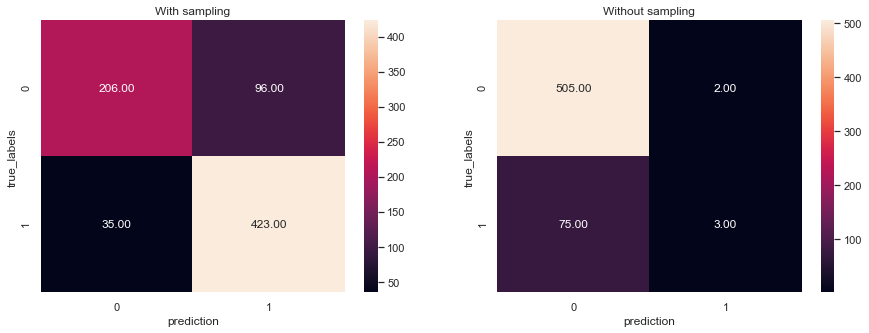

In [54]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

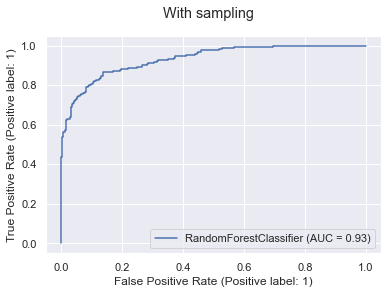

In [55]:
rf_disp = RocCurveDisplay.from_estimator(rf_model, X_test_std, y_test)
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

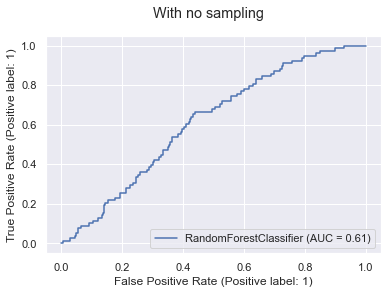

In [56]:
rf_disp = RocCurveDisplay.from_estimator(rf_model, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

## KNN

In [57]:
knn_model = KNeighborsClassifier(n_jobs=1, weights='distance')
knn_model.fit(X_train_std, y_train)
y_pred = knn_model.predict(X_test_std)

knn_model_ns = KNeighborsClassifier(n_jobs=1, weights='distance', n_neighbors=10)
knn_model_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = knn_model_ns.predict(X_test_ns_std)

In [58]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'KNN')

,Accuracy,Precision,Recall,F1
KNN,0.864474,0.818671,0.995633,0.898522
KNN (not sampled),0.866667,0.500000,0.038462,0.071429


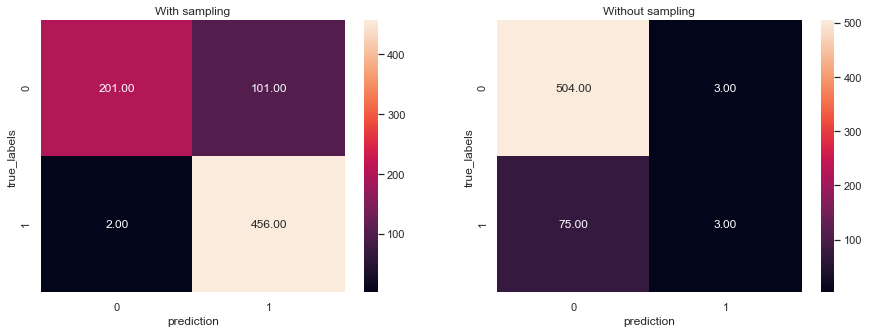

In [59]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

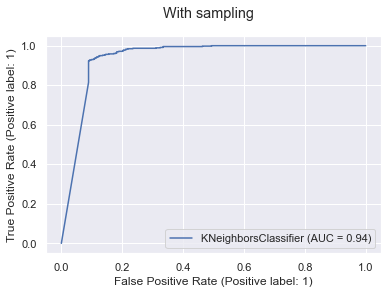

In [60]:
knn_disp = RocCurveDisplay.from_estimator(knn_model, X_test_std, y_test)
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

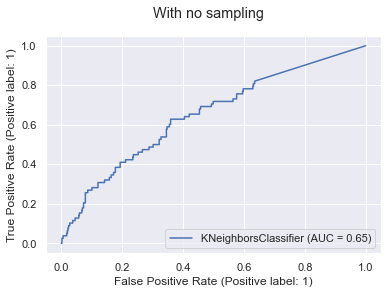

In [61]:
knn_disp_ns = RocCurveDisplay.from_estimator(knn_model_ns, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

## VotingClassifier

In [62]:
eclf = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('svm', svc_model), 
                                             ('knn', knn_model)], voting='hard')
eclf.fit(X_train_std, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.2, solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=6,
                                                     min_samples_split=4,
                                                     n_estimators=1000,
                                                     n_jobs=2,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=1, probability=True, random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=1,
                                                   weights='distance'))])

In [63]:
models = ['LogisticRegression', 'RandomForest', 'SVC', 'KNN', 'VotingClassifier']
count = 0
for clf in (lr_model, rf_model, svc_model, knn_model, eclf):
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict(X_test_std)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(models[count])
    print(f'Precision is {precision}\nRecall is {recall}\nAccuracy is {accuracy}\nF1 is {f1}')
    print('-' * 50)
    count += 1

LogisticRegression
Precision is 0.7631067961165049
Recall is 0.8580786026200873
Accuracy is 0.7539473684210526
F1 is 0.8078108941418294
--------------------------------------------------
RandomForest
Precision is 0.815028901734104
Recall is 0.9235807860262009
Accuracy is 0.8276315789473684
F1 is 0.8659160696008187
--------------------------------------------------
SVC
Precision is 0.827037773359841
Recall is 0.9082969432314411
Accuracy is 0.8302631578947368
F1 is 0.8657648283038502
--------------------------------------------------
KNN
Precision is 0.8186714542190305
Recall is 0.9956331877729258
Accuracy is 0.8644736842105263
F1 is 0.8985221674876848
--------------------------------------------------
VotingClassifier
Precision is 0.8247011952191236
Recall is 0.9039301310043668
Accuracy is 0.8263157894736842
F1 is 0.8625
--------------------------------------------------


## XGBoost

In [82]:
xgb = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, 
                    booster='gbtree', validate_parameters=True)
xgb.fit(X_train_std, y_train)
y_pred = xgb.predict(X_test_std)

xgb_ns = XGBClassifier(max_depth=5, learning_rate=0.001, n_estimators=660, 
                    booster='gbtree', validate_parameters=True)
xgb_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = xgb_ns.predict(X_test_ns_std)

In [83]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'XGBoost')

,Accuracy,Precision,Recall,F1
XGBoost,0.927632,0.931478,0.949782,0.940541
XGBoost (not sampled),0.870085,0.666667,0.051282,0.095238


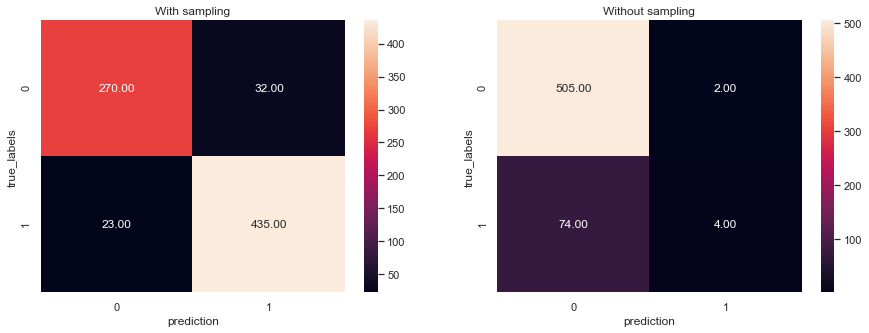

In [84]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

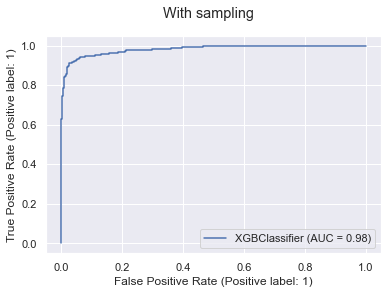

In [85]:
rgb_disp = RocCurveDisplay.from_estimator(xgb, X_test_std, y_test)
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

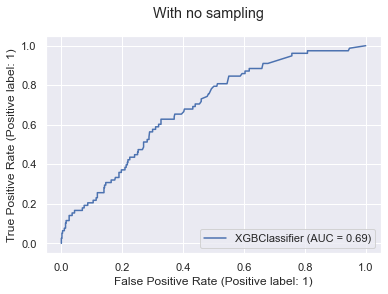

In [86]:
rgb_disp_ns = RocCurveDisplay.from_estimator(xgb_ns, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

## Catboost

In [100]:
catboost = CatBoostClassifier(learning_rate=0.2, iterations=1000, loss_function='CrossEntropy', depth=10, verbose=False)
catboost.fit(X_train_std, y_train)
y_pred = catboost.predict(X_test_std)

catboost_ns = CatBoostClassifier(learning_rate=1, iterations=500, loss_function='CrossEntropy', depth=4, verbose=False)
catboost_ns.fit(X_train_ns_std, y_train_ns)
y_pred_ns = catboost_ns.predict(X_test_ns_std)

In [102]:
show_metrics(y_test, y_pred, y_test_ns, y_pred_ns, 'Catboost')

,Accuracy,Precision,Recall,F1
Catboost,0.936842,0.928870,0.969432,0.948718
Catboost (not sampled),0.820513,0.245283,0.166667,0.198473


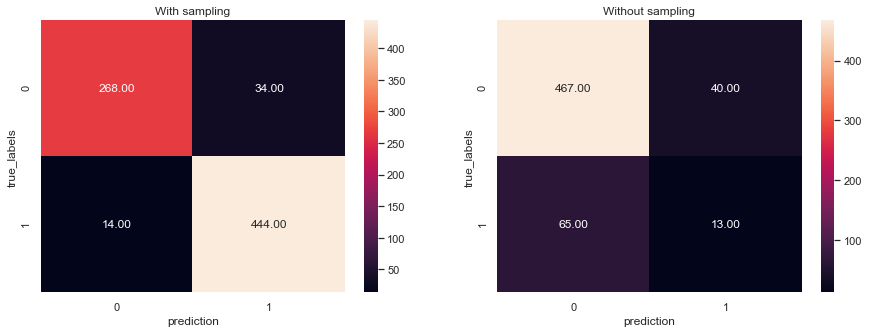

In [103]:
show_confusion_matrix(y_test, y_pred, y_test_ns, y_pred_ns)

Text(0.5, 0.98, 'With sampling')

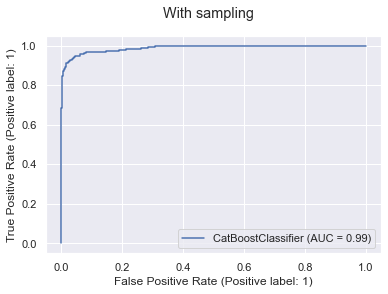

In [104]:
cat_disp = RocCurveDisplay.from_estimator(catboost, X_test_std, y_test)
plt.suptitle('With sampling')

Text(0.5, 0.98, 'With no sampling')

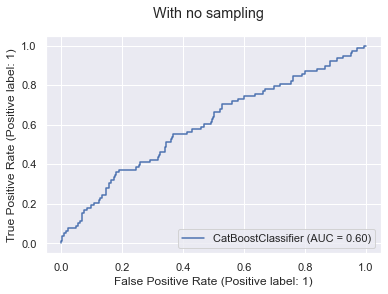

In [105]:
cat_disp_ns = RocCurveDisplay.from_estimator(catboost_ns, X_test_ns_std, y_test_ns)
plt.suptitle('With no sampling')

# Conclusion

The best indicators of metrics **recall, f1, ROC** were shown by models (in descending order) **Catboost, XGBoost, KNN**. 
If you need to maximize the **recall** metric, then you can take the **KNN** model. We could also combine it with parameters using **GridSearch** or **optuna** , but we have already achieved good results, which completely satisfies me.